<div style="border: 2px solid red; padding: 10px; border-radius: 5px;">
<strong>Notebook description:</strong>
    
Plotting p.Tyr622* + / - CDP-choline LCMS lipidomics results

<strong>Input Data:</strong>

`SUB14737/5041.SUB14737_LipidXData.csv` 


<strong>Figures:</strong>

`Fig4`
`ED12`

<strong>Last Run All:</strong>
June 18, 2025


In [1]:
import sys
sys.path.append('/Users/djuna/Documents/ABCA7lof2/')

from ABCA7lof2.utils import apply_custom_plot_style
apply_custom_plot_style()

In [4]:
import os
import urllib.request
import numpy as np
import pandas as pd
from scipy.stats import ttest_ind
from statsmodels.stats.multitest import multipletests
os.sys.path.append('/Users/djuna/Documents/ABCA7lof2/')
from ABCA7lof2.lcms_funcs import return_stats, plot_volcano, plot_pca, count_unsaturations, count_carbons, plot_lfcs, plot_carbon_distributions, plot_class_counts, plot_with_blank, classify_fatty_acid_length, classify_unsaturation
# load libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from adjustText import adjust_text
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Rectangle
from matplotlib.lines import Line2D


load data

In [6]:
output_dir = "../../../LCMS/"

# load data
data = pd.read_csv(output_dir + '5041.SUB14737_LipidXData.csv')
data['score'] = -np.log10(data['p_value[s2-over-s1]']) * np.sign(data['log_ratio[s2-over-s1]'])
data.index = data['name']

# load lipid key
key = pd.read_csv(os.path.join(output_dir, 'LipidKey.csv'))
dictionary = dict(zip(key['Key'], key['Class']))

# sample key 
sample_dictionary = {'s1':'H2O',
                     's2':'CDP-Choline',
                     's3':'Extraction blank',
                     'c]':'Solvent blank'}


lipid_palette = {
    'Sphingolipids':'#1DC9A4',
    'Neutral lipids':'#E3120B',
    'Phospholipids':'#475ED1',
    'Fatty acyl and other lipids':'#F97A1F', 
    'Neutral glycerolipid':'#E3120B',	
    'Steroid':'#F9C31F', 
    'Glycoglycerolipids':'darkblue'
}

pufa_palette = {
    'PUFA':'#333333',
    'MUFA':'#1F2E7A',
    'SFA':'#475ED1'
}

key = pd.read_csv(os.path.join(output_dir, 'LipidKey.csv'))
dictionary = dict(zip(key['Key'], key['Class']))


perform stats

In [7]:
# annotate the classes
data['group'] = data['class'].map(dictionary)
data['class'].unique()

# get areas
areas = data[[col for col in data.columns if col.startswith('area[')]]
names = np.array([x.split('[')[1][:2] for x in areas.columns])
areas_columns = np.array([sample_dictionary[x] for x in names])
names_no_blank = areas_columns[:-1]

# subtract blank
areas_no_blank = areas.iloc[:,areas_columns!='Extraction blank']
ext_blank = areas.iloc[:, areas_columns == 'Extraction blank'].squeeze()

# remove extraction blank
areas_no_blank_H20_blank_removed = areas_no_blank.subtract(3*ext_blank, axis=0)

# set neg values to zero
areas_no_blank_H20_blank_removed_zeroed = areas_no_blank_H20_blank_removed.copy()
areas_no_blank_H20_blank_removed_zeroed[areas_no_blank_H20_blank_removed_zeroed < 0] = 0

# get significant compounds
stats = return_stats(areas_no_blank_H20_blank_removed_zeroed, names_no_blank, 'H2O', 'CDP-Choline', equal_var=True)
stats['cat'] = 'other'
stats['name'] = stats.index
stats['grp'] = [dictionary[x.split('(')[0]] for x in stats.index]

# Drop rows where fold change is NaN
stats = stats.dropna(subset=['p_value'])

# correct pvalues
stats['fdr_corrected_p_value'] = multipletests(stats['p_value'], method='fdr_bh')[1]

# add class column
stats['class'] = [x.split('(')[0] for x in stats.index]

# add unsaturation and carbon length column 
stats['carbons'] = stats['name'].apply(count_carbons)
stats['unsaturations'] = stats['name'].apply(count_unsaturations)
stats['unsat_grp'] = [classify_unsaturation(count_unsaturations(x)) for x in stats.index]


# categorize species
stats['cat'] = 'other'
stats.loc[(stats['log2_fold_change']< -1) & (stats['fdr_corrected_p_value']<0.05), 'cat'] = 'down'
stats.loc[(stats['log2_fold_change']>1) & (stats['fdr_corrected_p_value']<0.05), 'cat'] = 'up'
stats['cat'] = stats['cat'].astype(str)

stats.head()

/Users/djuna/Documents/ABCA7lof2/ABCA7lof2/lcms_funcs.py:33: RuntimeWarning: divide by zero encountered in log2
  log2_fold_change = np.log2(mean_group2 / mean_group1) if mean_group1 != 0 else np.inf


,t_stat,p_value,log2_fold_change,fdr_corrected_p_value,cat,name,grp,class,carbons,unsaturations,unsat_grp
Cer(d16:0_16:0)+H_53.21,-1.652058,0.137126,-3.152181,0.601567,other,Cer(d16:0_16:0)+H_53.21,Sphingolipids,Cer,32,0,SFA
Cer(d18:0_16:0)+H_41.29,-0.560525,0.590470,-0.695298,0.865391,other,Cer(d18:0_16:0)+H_41.29,Sphingolipids,Cer,34,0,SFA
Cer(d18:1_14:0)+H-H2O_39.3,0.487443,0.639021,0.272482,0.883141,other,Cer(d18:1_14:0)+H-H2O_39.3,Sphingolipids,Cer,32,1,MUFA
Cer(d18:1_14:0)+H_39.3,0.450326,0.664429,0.253561,0.888152,other,Cer(d18:1_14:0)+H_39.3,Sphingolipids,Cer,32,1,MUFA
Cer(d18:1_16:0)+H-H2O_40.9,-0.247099,0.811055,-0.118390,0.915227,other,Cer(d18:1_16:0)+H-H2O_40.9,Sphingolipids,Cer,34,1,MUFA


In [8]:
names_no_blank

array(['H2O', 'H2O', 'H2O', 'H2O', 'H2O', 'CDP-Choline', 'CDP-Choline',
       'CDP-Choline', 'CDP-Choline', 'CDP-Choline'], dtype='<U16')

get replicate counts & save stats

In [5]:
np.unique(areas_columns, return_counts=True)

(array(['CDP-Choline', 'Extraction blank', 'H2O'], dtype='<U16'),
 array([5, 1, 5]))

In [6]:
stats.to_csv('../../../extended_tables/lcms_choline.csv')

Look at blanks

/Users/djuna/Library/Python/3.9/lib/python/site-packages/seaborn/categorical.py:3399: UserWarning: 40.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/djuna/Library/Python/3.9/lib/python/site-packages/seaborn/categorical.py:3399: UserWarning: 20.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/djuna/Library/Python/3.9/lib/python/site-packages/seaborn/categorical.py:3399: UserWarning: 60.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


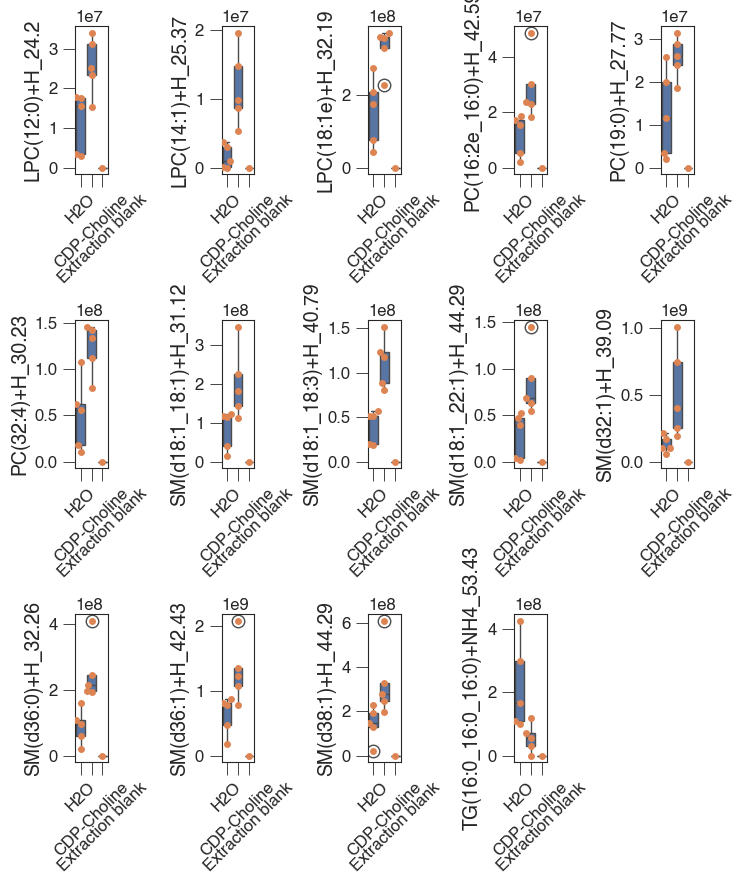

In [7]:
# show sig lipids with blanks
areas_sub = areas.loc[stats[(stats['p_value']<0.05) & (np.abs(stats['log2_fold_change'])>1)].index].iloc[:,(areas_columns=='H2O') | (areas_columns=='CDP-Choline') | (areas_columns=='Extraction blank')]
areas_sub.columns = areas_columns[(areas_columns=='H2O') | (areas_columns=='CDP-Choline') | (areas_columns=='Extraction blank')]
areas_sub = areas_sub.T
areas_sub['grp'] = areas_sub.index
plot_with_blank(areas_sub)

plot the TGs

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


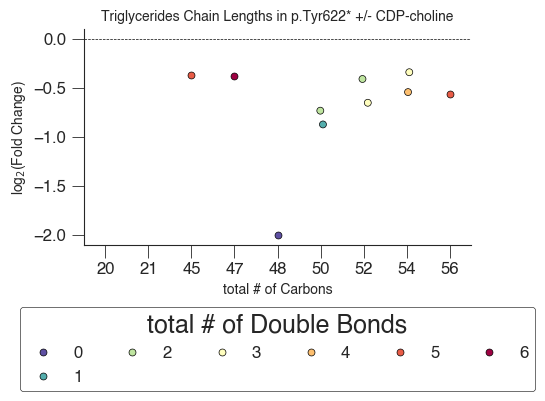

In [8]:
temp = stats[stats['class']=='TG'].copy()
plt.figure(figsize=(5, 2.8))
#
sp = sns.stripplot(data=temp, x='carbons', y='log2_fold_change', jitter=0.1, alpha = 1, hue = 'unsaturations', color = 'black', palette = 'Spectral_r', edgecolor='black', linewidth=0.5)

sp.spines['top'].set_visible(False)
sp.spines['right'].set_visible(False)

legend = plt.legend(bbox_to_anchor=(0.5, -0.25), loc='upper center', ncol=6, frameon=True, title='total # of Double Bonds')
legend.get_frame().set_edgecolor('black')
legend.get_frame().set_linewidth(0.5)
plt.ylabel('log$_{2}$(Fold Change)', fontsize=10)
plt.xlabel('total # of Carbons', fontsize=10)
plt.title('Triglycerides Chain Lengths in p.Tyr622* +/- CDP-choline', fontsize=10)
plt.axhline(0, color='black', linewidth=0.5, linestyle='--')

#plt.xlim(-1,9)
plt.savefig('/Users/djuna/Documents/ABCA7lof2/editorial_paper/main_panels_svgs/ed12/tg_carbons_with_choline_batch1.pdf', dpi=300, bbox_inches='tight')


plot PCS

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


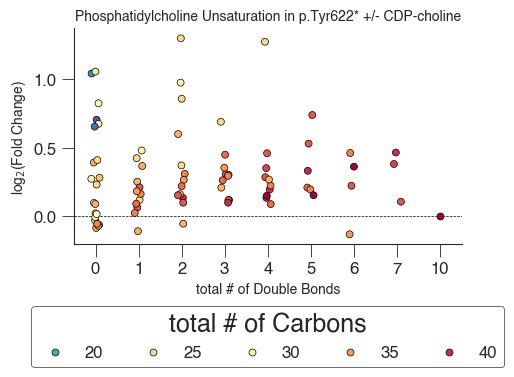

In [9]:
temp = stats[stats['class']=='PC'].copy()
plt.figure(figsize=(5, 2.8))
#
sp = sns.stripplot(data=temp, x='unsaturations', y='log2_fold_change', jitter=0.1, alpha = 1, hue = 'carbons', color = 'black', palette = 'Spectral_r', edgecolor='black', linewidth=0.5)

sp.spines['top'].set_visible(False)
sp.spines['right'].set_visible(False)

legend = plt.legend(bbox_to_anchor=(0.5, -0.25), loc='upper center', ncol=6, frameon=True, title='total # of Carbons')
legend.get_frame().set_edgecolor('black')
legend.get_frame().set_linewidth(0.5)
plt.ylabel('log$_{2}$(Fold Change)', fontsize=10)
plt.xlabel('total # of Double Bonds', fontsize=10)
plt.title('Phosphatidylcholine Unsaturation in p.Tyr622* +/- CDP-choline', fontsize=10)
plt.axhline(0, color='black', linewidth=0.5, linestyle='--')

#plt.xlim(-1,9)
plt.savefig('/Users/djuna/Documents/ABCA7lof2/editorial_paper/main_panels_svgs/ed12/pc_unsat_with_choline_batch1.pdf', dpi=300, bbox_inches='tight')


Plot volcano 

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


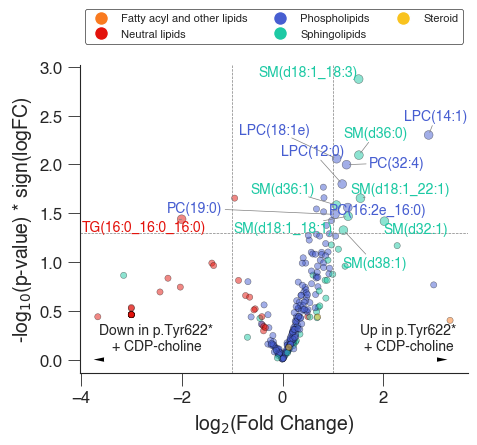

In [10]:
stats_for_volcano = stats.copy()
stats_for_volcano.loc[stats_for_volcano['log2_fold_change']==-np.inf, 'log2_fold_change'] = -3
stats_for_volcano.loc[stats_for_volcano['log2_fold_change']==np.inf, 'log2_fold_change'] = 3

plot_volcano('p_value', 'name', 'grp', 'log2_fold_change',stats_for_volcano, lipid_palette, force_text=35,min_size=20, max_size=40, alpha=0.5, subset_top_genes_by_lfc=True)

# plt.ylim(-0.1,4)
# plt.xlim(-3,2)
plt.axvline(x=-1, color='grey', linestyle='--', linewidth=0.5)
plt.axvline(x=1, color='grey', linestyle='--', linewidth=0.5)
plt.axhline(y=1.3, color='grey', linestyle='--', linewidth=0.5)

plt.xlabel('log$_{2}$(Fold Change)')
plt.ylabel('-log$_{10}$(p-value) * sign(logFC)')

plt.annotate('', xy=(3.5,0), xytext=(1, 0),
             arrowprops=dict(facecolor='black', shrink=0.05, width=.1, headwidth=5))
plt.text(2.5, .1, 'Up in p.Tyr622*\n+ CDP-choline', ha='center', fontsize=10)

plt.annotate('', xy=(-4,0), xytext=(-1, 0),
             arrowprops=dict(facecolor='black', shrink=0.05, width=.1, headwidth=5))
plt.text(-2.5, .1, 'Down in p.Tyr622*\n+ CDP-choline', ha='center', fontsize=10)


labels = np.unique(stats_for_volcano['grp'])[[x!='Neutral glycerolipid' for x in np.unique(stats_for_volcano['grp'])]]

handles = [
    Line2D([0], [0], marker='o', color='w', label=label,
           markerfacecolor=lipid_palette[label], markersize=10)
    for label in labels
]

legend = plt.legend(handles=handles, loc='upper center', bbox_to_anchor=(.5, 1.2), ncol=3, frameon=True, fontsize=8)
legend.get_frame().set_edgecolor('black')
legend.get_frame().set_linewidth(.5)


plt.savefig('/Users/djuna/Documents/ABCA7lof2/editorial_paper/main_panels_svgs/fig4/all_lipids_choline_batch1.pdf', dpi=300, bbox_inches='tight')

